# Question A1 (15 marks)

#### Design a feedforward deep neural network (DNN) which consists of **three** hidden layers of 128 neurons each with ReLU activation function, and an output layer with sigmoid activation function. Apply dropout of probability **0.2** to each of the hidden layers.

* note: some cells are non-editable and cannot be filled, but leave them untouched. Fill up only cells which are provided.

In [9]:
import tqdm
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from scipy.io import wavfile as wav

from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

from common_utils import set_seed

# setting seed
set_seed()

1. Define the model class.

In [10]:
class MLP(nn.Module):

    def __init__(self, no_features, no_hidden, no_labels):
        super().__init__()
        self.mlp_stack = nn.Sequential(
            # YOUR CODE HERE
            # To Build: three hidden layers of 128 neurons each with ReLU activation function
            # Apply dropout of probability 0.2 to each of the hidden layers

            # Input Layer --> First Hidden Layer
            nn.Linear(no_features, no_hidden),
            nn.ReLU(),
            nn.Dropout(0.2),

            # First Hidden Layer --> Second Hidden Layer
            nn.Linear(no_hidden, no_hidden),
            nn.ReLU(),
            nn.Dropout(0.2),

            # Second Hidden Layer --> Third Hidden Layer
            nn.Linear(no_hidden, no_hidden),
            nn.ReLU(),
            nn.Dropout(0.2),

            # Third Hidden Layer --> Output Layer
            # Output layer with sigmoid activation function
            nn.Linear(no_hidden, no_labels),
            nn.Sigmoid()
        )

    # YOUR CODE HERE
    def forward(self, x):
        return self.mlp_stack(x)

#### Divide the dataset into a 70:30 ratio for training and testing. Use **appropriate** scaling of input features. We solely assume that there are only two datasets here: training & test.

1. Split the dataset and do preprocessing.

In [11]:
from common_utils import split_dataset, preprocess_dataset


def preprocess(df):
    # YOUR CODE HERE
    # use df created below
    # Don't want to give model access to the information it is trying to predict,
    # hence columns_to_drop = filename, label (contains the desired output: neg/pos)
    # since the dataset is to be divided into 70:30 ratio for training and testing, test_size = 0.3
    # Assumption: no random_state specified hence set random_state = 0
    # split_dataset function returns: df_train2, y_train2, df_test2, y_test2
    X_train, y_train, X_test, y_test = split_dataset(df, ['filename', 'label'], 0.3, 0)

    # return requires scaled X_train and X_test values (to maintain consistency)
    X_train_scaled, X_test_scaled = preprocess_dataset(X_train, X_test)

    return X_train_scaled, y_train, X_test_scaled, y_test

df = pd.read_csv('simplified.csv')
df['label'] = df['filename'].str.split('_').str[-2]

df['label'].value_counts()

X_train_scaled, y_train, X_test_scaled, y_test = preprocess(df)

#### Use the training dataset to train the model for 100 epochs. Use a mini-batch gradient descent with **‘Adam’** optimizer with learning rate of **0.001**, and **batch size = 256**. Implement early stopping with patience of **3**.

1. Define a Pytorch Dataset and Dataloaders.  

In [12]:
class CustomDataset(Dataset):
    # YOUR CODE HERE
    def __init__(self, X, y):
        # Convert X and y to PyTorch tensors with the appropriate data types.
        self.X = torch.tensor(X, dtype=torch.float32)
        # model output shape is (X, 1), hence need to reshape labels from 1D to 2D
        self.y = torch.tensor(y, dtype=torch.float32).reshape(-1, 1)

    def __len__(self):
        # return the total number of samples in the dataset
        return len(self.X)

    def __getitem__(self, idx):
        # to retrieve a specific sample by its index (idx)
        x_sample = self.X[idx] # Get the input features of the sample.
        y_sample = self.y[idx] # Get the label (target) of the sample.
        return x_sample, y_sample


def intialise_loaders(X_train_scaled, y_train, X_test_scaled, y_test):
    # YOUR CODE HERE
    # create train and test datasets
    train_dataset = CustomDataset(X_train_scaled, y_train)
    test_dataset = CustomDataset(X_test_scaled, y_test)

    # create train and test dataloaders
    # required batch size = 256
    # introduce randomness and prevent the model from learning the order of the data
    # hence, shuffle = True
    train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=256, shuffle=True)

    return train_dataloader, test_dataloader

train_dataloader, test_dataloader = intialise_loaders(X_train_scaled, y_train, X_test_scaled, y_test)

2. Next, define the model, optimizer and loss function.

In [13]:
# YOUR CODE HERE
# no of columns (exlcuding filename) = 77
# hidden layers of 128 neurons
# output neuron = 1, only need to predict whether it is pos/neg
model = MLP(77, 128, 1)
# ‘Adam’ optimizer with learning rate of 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# since there are 2 classes, BCELoss as loss function
loss_function = nn.BCELoss()

3. Train model for 100 epochs. Record down train and test accuracies. Implement early stopping.

In [14]:
# YOUR CODE HERE
from common_utils import EarlyStopper

# to record accuracy and loss of training
acc_train = []
loss_train = []

# to record accuracy and loss of test
acc_test = []
loss_test = []

# early stopping with patience of 3
early_stopper = EarlyStopper(patience=3)

# Train model for 100 epoch
for i in range(100):
    # model to training mode
    model.train()
    # mini-batch gradient descent
    for X_batch, y_batch in train_dataloader:
        # Zero out the gradients
        optimizer.zero_grad()
        # Forward pass to compute predictions
        y_pred = model(X_batch)
        # Compute the loss between predictions and true labels & backpropagate gradients
        loss_function(y_pred, y_batch).backward()
        # Update model parameters using optimizer
        optimizer.step()

    # model to evaluation mode
    model.eval()
    with torch.no_grad():
        # store loss and accuracy values
        total_loss = []
        total_acc = []

        # Evaluate on the training dataset
        for X_batch, y_batch in train_dataloader:
            # Forward pass to compute predictions
            y_pred = model(X_batch)

            # Calculate accuracy by comparing rounded predictions to true labels
            acc = (y_pred.round() == y_batch).float().mean()
            total_acc.append(float(acc))

            # Compute the loss for this mini-batch
            loss = loss_function(y_pred, y_batch)
            total_loss.append(loss.detach().numpy())

        # Calculate and store average training accuracy and loss for this epoch
        acc_train.append(sum(total_acc) / len(total_acc))
        loss_train.append(sum(total_loss) / len(total_loss))

        # store per-epoch loss and accuracy values for the test dataset
        total_loss = []
        total_acc = []

        # Evaluate on the test dataset
        for X_batch, y_batch in test_dataloader:
            # Forward pass to compute predictions
            y_pred = model(X_batch)

            # Calculate accuracy by comparing rounded predictions to true labels
            acc = (y_pred.round() == y_batch).float().mean()
            total_acc.append(float(acc))

            # Compute the loss for this mini-batch
            loss = loss_function(y_pred, y_batch)
            total_loss.append(loss.detach().numpy())

        # Calculate and store average test accuracy and loss for this epoch
        acc_test.append(sum(total_acc) / len(total_acc))
        loss_test.append(sum(total_loss) / len(total_loss))

    # check: print progress every 10 epochs
    if i % 10 == 0:
        print(f"Epoch: {i}, Train Accuracy: {acc_train[-1]*100:.2f}%, Train Loss: {loss_train[-1]}, Test Accuracy: {acc_test[-1]*100:.2f}%, Test Loss: {loss_test[-1]}")

    # Check for early stopping based on test loss (based on lecture notes)
    if early_stopper.early_stop(loss_test[-1]):
        print(f"Early stopping implemented at epoch {i}.")
        break

Epoch: 0, Train Accuracy: 57.00%, Train Loss: 0.6800252867467476, Test Accuracy: 55.68%, Test Loss: 0.6841142495473226
Epoch: 10, Train Accuracy: 77.18%, Train Loss: 0.48935530312133557, Test Accuracy: 69.88%, Test Loss: 0.5777382989724477
Epoch: 20, Train Accuracy: 86.23%, Train Loss: 0.34961123899980023, Test Accuracy: 73.37%, Test Loss: 0.5360496004422506
Early stopping implemented at epoch 21.


#### Plot train and test accuracies and losses on training and test data against training epochs and comment on the line plots.


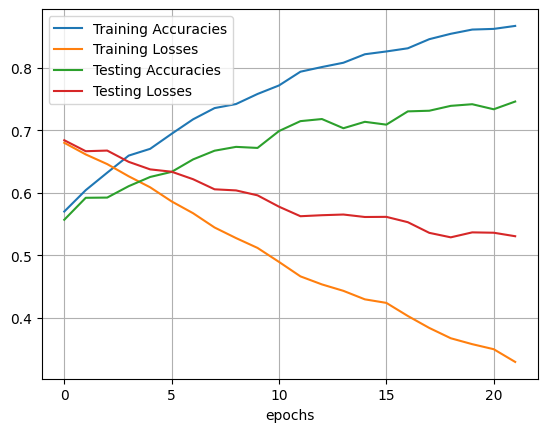

In [15]:
# YOUR CODE HERE
plt.plot(acc_train, label="Training Accuracies")
plt.plot(loss_train, label="Training Losses")
plt.plot(acc_test, label="Testing Accuracies")
plt.plot(loss_test, label="Testing Losses")

plt.xlabel("epochs")
plt.grid(True)  # Add gridlines for better readability
plt.legend()

2. Comment on line plots.

In [16]:
# YOUR CODE HERE
answer = "The neural network is learning well, with decreasing training loss and increasing training accuracy. However, after around epoch 18, there is a sudden increase in testing loss, which could be a sign of overfitting."
answer

'The neural network is learning well, with decreasing training loss and increasing training accuracy. However, after around epoch 18, there is a sudden increase in testing loss, which could be a sign of overfitting.'